## Описание проекта


Прогнозируем количество заказов такси в аэропорт

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Подготовка

In [2]:
data=pd.read_csv('./datasets/taxi.csv', index_col=0, parse_dates=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [5]:
data.index.is_monotonic

True

In [6]:
#Произведём ресемплирование по 1 часу
data=data.resample('1H').sum()

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


**Вывод**: среди 26496 записей нет пустых значений. Данные в таблице расположены в хронологическом порядке. Ресемплирование осуществляется по сумме, т.е. предполагается что в исходной таблице num_orders соответствует количеству новых заказов в текущий момент

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
данные на базе)

# 2. Анализ

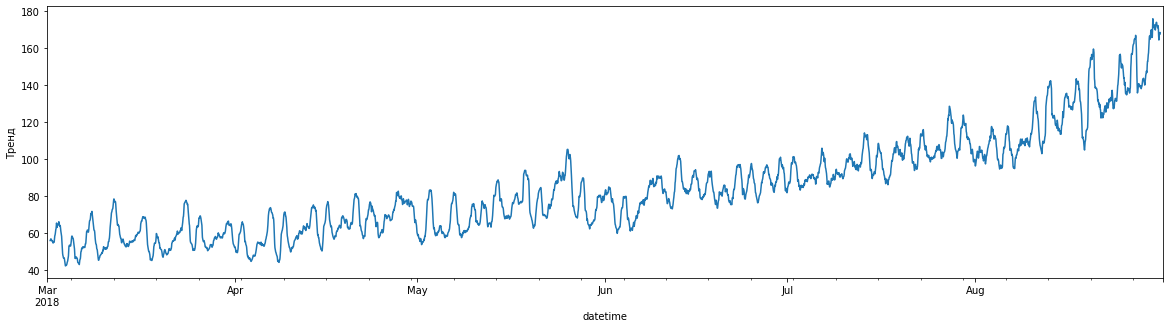

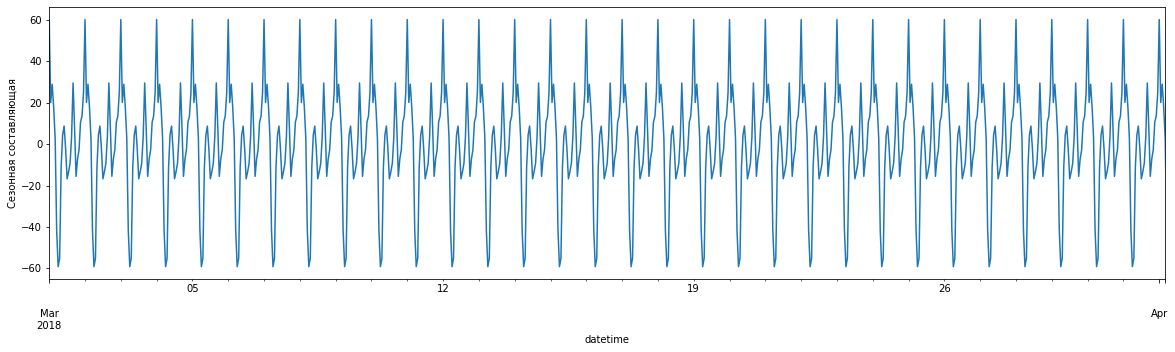

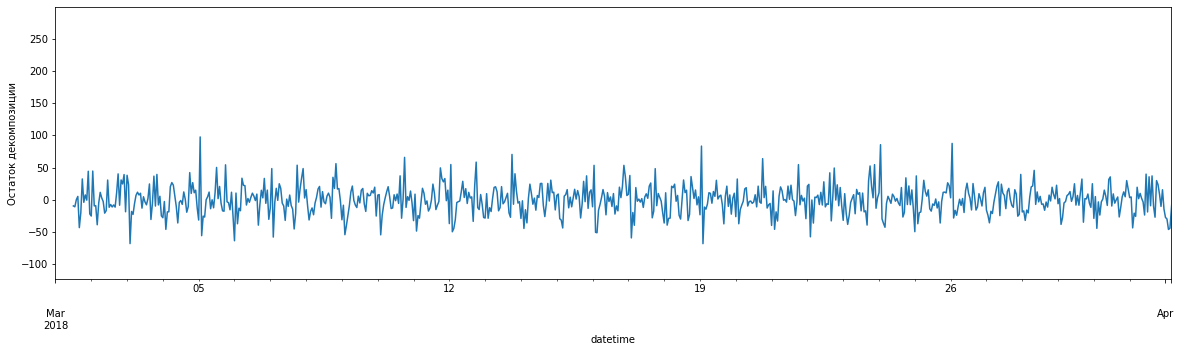

In [8]:
decomposed = seasonal_decompose(data['num_orders'])

#Тренд
trend=decomposed.trend
trend.plot(figsize=(20,5))
plt.ylabel('Тренд')
plt.show()

#сезонная составляющая
seasonal=decomposed.seasonal
seasonal.plot(figsize=(20,5), xlim=('2018-03-01 00:00:00','2018-04-01 04:00:00'))
plt.ylabel('Сезонная составляющая')
plt.show()

#Ошибка
resid=decomposed.resid 
resid.plot(figsize=(20,5), xlim=('2018-03-01 00:00:00','2018-04-01 04:00:00'))
plt.ylabel('Остаток декомпозиции')
plt.show()

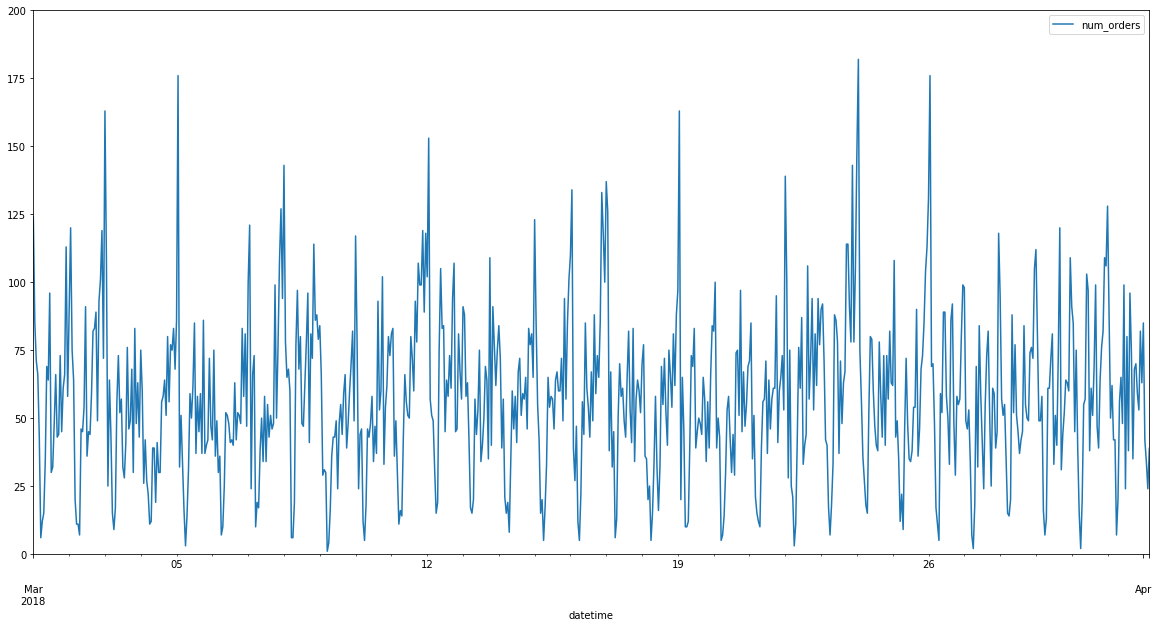

In [9]:
#Постмотрим что отобразит
data.plot(figsize=(20,10),
          xlim=('2018-03-01 00:00:00','2018-04-01 04:00:00'),
         ylim=(0,200))
plt.show()

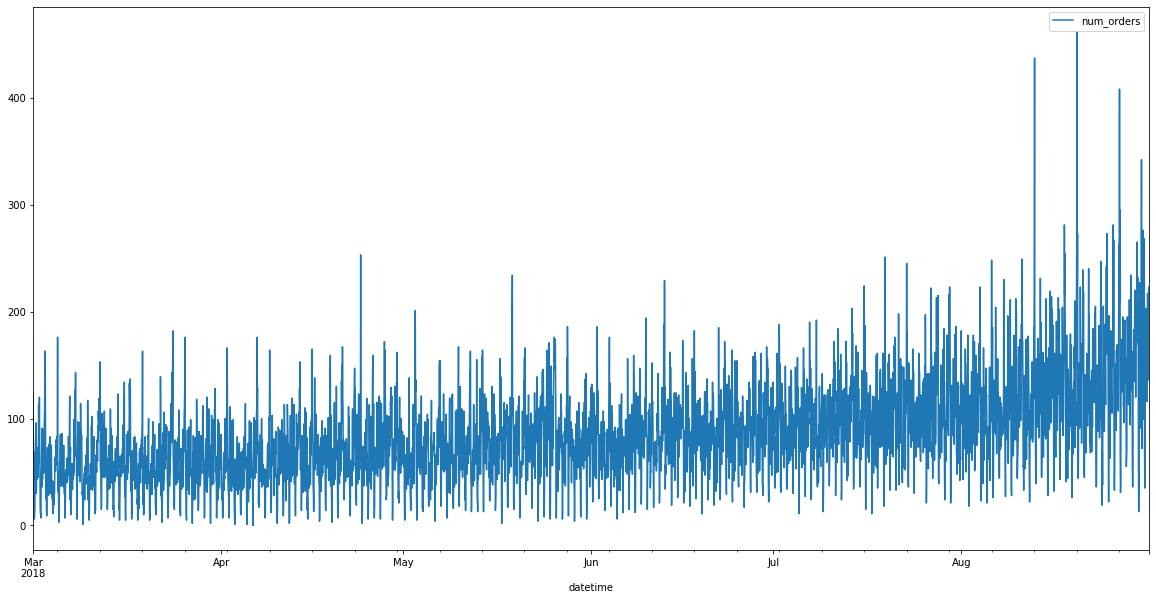

In [10]:
#Постмотрим что отобразит
data.plot(figsize=(20,10))
plt.show()

**Вывод**: как видно из графиков, полученных в результате разложения в исходном временном ряде наблюдается восходящей тренд с явно выраженной сезонностью, которая повторяется каждый день и наибольшее число заказов приходится на вечер, а меньше всего заказов после полуночи и ближе к утру. Рассматриваемый временной ряд не относится к числу стационарных, потому что у него меняется спеднее значение со временем.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Есть три вида нестационарности: тренд, сезонность, непостоянство дисперсии)<br>
Стационарный ряд - это когда ничего из перечисленного в ряде не наблюдается (очистили его). Нужно это для одного из методов прогрнозироваия АРИМА, например. Для нашегго метода прогнозирования это понятие можно не использовать.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Исследование - понятно, хорошо, что глянули график на коротком периоде<br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - очень нужный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это очень помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1)дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2)Но ведь есть ещё внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером (об этом Вы сказали) <br>
3)Ну и наконец есть месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных (и Вы об этом пишите) восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.
</font>

<div class="alert alert-block alert-info">
Объясни мне, пожалуйста, как понимать графики сезонности и тренда. Важны ли там амплитуда и частота, они что-то значат?<br>
И почему ты говорить, что у стационарного ряда не может быть сезонности. Я думал что стационарный ряд - это ряд, в котором не меняется уровень, т.е. тренд не наблюдается.
</div>

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2 (27/08/2020)</u>
</font>
<font color='green'>
Временной ряд - это реальные продажи бизнеса.<br>
Попробую на упрощённом примере расписать тренд, сезонность и ошибки.<br>
    
Возьмём для примера упрощённое видение<br>
есть город, в нём 100 человек жиыёт<br>
Каждый из них покупает себе бутылку воды<br>
Итого у нас продажи: 100 бутылок каждый день - прямая линия на графике.<br>
    
Предположим дополнительную ситуацию: количество жителей увеличивается на 1 каждый день. И каждый из них - тоже водохлёб<br>
Тогда наши продажи будут увеличиваться на 1 каждый день - т.е будет тренд<br>
Т.е. наклонная линия на графике<br>
    
Следующая ситуация: <br>
Летом воды пьём больше, зимой меньше. Причём так: летом по 2 бутылки, зимой по одной<br>
И если наложить эту ситуацию на первый случай (просто 100 человек)<br>
то будем иметь на графике прямую волнистую линию - синусоду.<br>
Это есть сезонность времени года.<br>
    
А если наложить эту ситуацию на второй случай (прибавление населения города)<br>
то будем иметь на графике восходящую волнистую линию - синусоду вверх.<br>

Что всё это демонстрирует:<br>
продажи = тренд + сезонность.<br> 
    
А если наложить жизненые обстоятельства: кто-то хотел пойти купить бутылку воды, но подскользнулся, упал сломал ногу - остался без воды. А у нас продажи не случились. И допусти м таких случае много. ТОгда имеем ещё одну составляющую ряда - шум.<br>
Это то, что нельзя предсказать ни как. Это не определённость. (Чем она меньше, тем лучше. Но есть предел неопределённости, который нам не преодолеть. Т.е. есть всегда минимальная ошибка)<br>
Продажи = тренд + сезонность + шум
    
Вот именно эти сосатвляющие даёт декомпозиция<br>
    
Но жизнь сложнее....и есть вторая сезонность - недельная: по выходным пьём больше (сушняк)))<br>
Продажи = тренд + сезонность1 + сезонность2 + шум<br>
    
А теперь, наши маркетологи придумали акции, и в один из месяцев провели акцию<br>
Продажи = тренд + сезонность1 + сезонность2 + акция + шум<br>    
    
А есть ещё влияние продаж предыдущего дня (месяца): вчерашние продажи влияют на сегодняшние (у вас это обозначен lag)<br>
Продажи = тренд + сезонность1 + сезонность2 + акция + lag_1 + шум<br>       
    
А если внешний фактор - погода (температура воздуха) - тоже влияет<br>
Продажи = тренд + сезонность1 + сезонность2 + акция + lag_1 + Температура + шум<br>     

И т.д. Это и есть факторы продаж временного ряда. А по сути факторы продаж, которые мы и хотим учесть в моделях, чтобы иметь наиболее точный прогноз и анализ влияния каждого фактора.<br>
Как они соотносятся - это у каждого бизнеса - по разному.<br>

И тут важжным является то, как аналитик понимает тот бизнес, который хочет прогнозировать. От этого будет подбирать факторы.<br>
А потом уже модели подбирать<br>    

Как они соотносятся - это у каждого бизнеса - по разному.<br>
    
    
Чатота, спрашиваешь ты: Это и еть вид сезонности. Если данные фиксировались по часам - большая частта колебаний.<br>
Если данные фиксировались  по месяцам (январь, февраль) - меньшая чатота колебаний..<br> 
Т.е. понимание, что сезонность - это реакиций рынка на свои потребности. (вода, например).<br>
Поэтому амплитуда - это сила этой реакции.<br>

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2 (27/08/2020)</u>
</font>
<font color='green'>
А по стационарности: именно то, что тебе говорил. Стационарный ряд - это "голый" ряд. У него не должно быть тренда, сезона, непостоянства дисперсии.<br> Есть классики - Бокс и Дженкинс - разработчики метода прогнозирования АРИМА. У них 2 тома прекрасной математической выкладки по этому поводу:) Примерно с них ввелось понтие стационарности. ОНа была важна именно для примененения нового математического аппарата для построения прогноза. Т.е. они разработали метод прогнозирования. В общем-то неплохой. НО применить этот метод можно было только тогда, когда ряд очищен от тренда, сезона, непостоянной дисперсии. И назвали такие ряды стационарными. С тех пор и пошло...<br>
    
А когда регрессию применяешь - вообще всё равно стационарен ряд или нет. Работаем уже с факторами тренд, сезонность.

# 3. Обучение

In [11]:
def make_features(data, max_lag, rolling_mean_size,goal='num_orders'):
    '''
    Создаём признаки
    '''
    data['dayofweek'] = data.index.dayofweek
    data['hour']= data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[goal].shift(lag)

    data['rolling_mean']=data[goal].shift().rolling(rolling_mean_size).mean()

In [12]:
temp=data.copy()
make_features(temp,5,5)

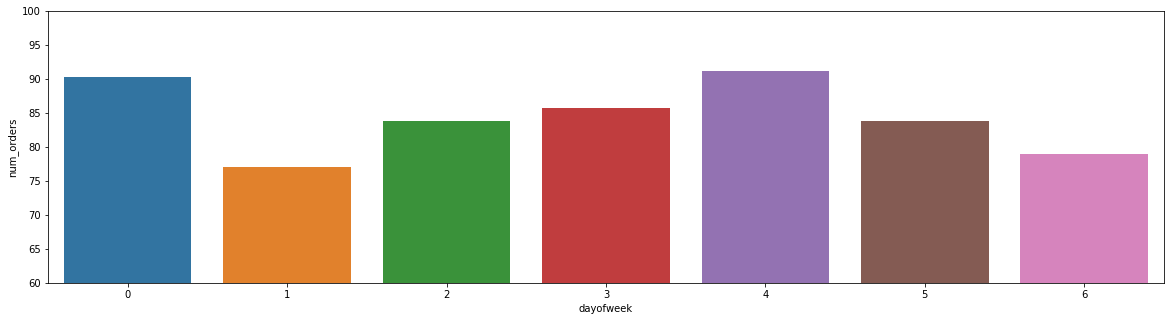

In [13]:
#Зависимость числа заказов от дней недели
temp_pivot=temp.pivot_table(index=['dayofweek'], values='num_orders', aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='dayofweek',y='num_orders',data=temp_pivot.reset_index())
plt.ylim(60,100)
plt.show()

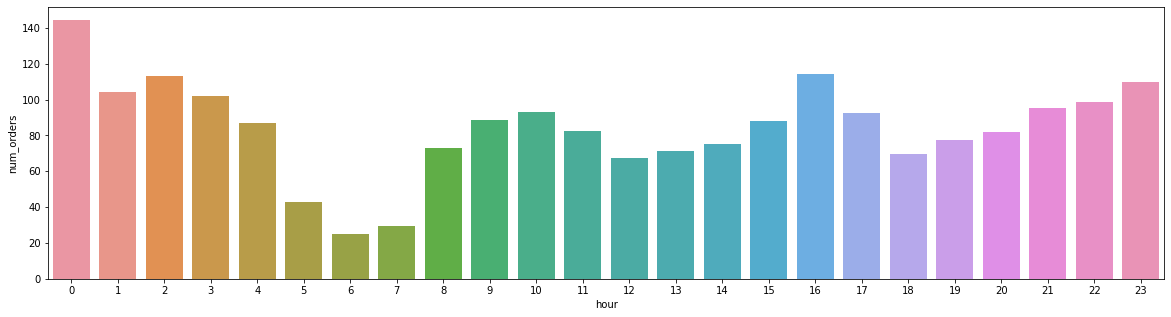

In [14]:
#Зависимость числа заказов от дней недели
temp_pivot=temp.pivot_table(index=['hour'], values='num_orders', aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='hour',y='num_orders',data=temp_pivot.reset_index())
#plt.ylim(60,100)
plt.show()

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Ты предлагаешь вот эти. А почему? Тут лучше ответить себе на этот вопрос?<br>
<font color='red'>
1) Фактор год: однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: аналогично году, у нас в истории всего один март, май....<br>
3) Фактор день: также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели:....<br>
5) Фактор час: ......<br>
6) Факто lag: .....<br>
7) Фактор rolling: ......<br>
    
Дай, пожалуйста, краткое описание, почему именно выбранные факторы взял в модель.<br>
Это один из ключевых моментов всей темы "временные ряды" - понимать составляющие ряда.<br>
Поэтому и прошу тебя сформулировать ответ на вопрос.

<div class="alert alert-block alert-info">
- Согласен, месяц и день ненужны при столь малом количестве данных <br>
- День недели важен, так как в в пятницу и в понедельник заказов такси в среднем больше,в остальные дни
- Фактор времени также важен, так как люди чаще заказывают такси утром на работу, вечером с работы, и поздно ночью чтобы добраться до дома когда закрыт общественный транспорт<br>
- Фактор временного лага важен, так как при столь малом временном шаге (1 час) можно предположить, что количество заказов такси в момент t будет примерно равен числу заказов в момент времени t-1<br>
- Фактор скользящего окна помогает сгладить выбросы и чем-то напоминает фактор лага, т.е. он содержит информацию о предыдущих заказах, которые будут примерно похожи на текущий<br>
</div>

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2 (27/08/2020)</u>
</font>
<font color='green'>
ОК, хорошо. Добавлю ещё пару комментариев:<br>
По лагам:<br>
Lag: его называют ещё параметром авторегрессии. На бытовом уровне его можно понять так: допустим вчера мы собрались с друзьями и не много закусили.... повлияет ли это на сегодняшний настрой на жизнь? Скорее да)))) Так вот с авторегрессией также. Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - воалияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br>
    
Обычно так происходит поиск параметров.<br>
1) узнаём , какая у нас сезонность: в нашем случае их две - часовая и день недели (суточная и недельная)<br>
2) Узнайм, какой у нас тренд. пусть будет пока rolling (12) - пол суток<br>
3) строим модель (без лагов).<br>
4) строим график автокорреляции остатков (факт - прогноз). Если видим "зубья" на сезонных лагах: 24, 24*7 - то мы плохо жанной моделью учли сезонность.<br> Если высокий "зуб" на на первом лаге, то ндо вводить в модель фактор lag=1.<br> и перестроить модель. И так по кругу.<br><br>
    
Глянь ещё тему "анализ остатков" гден-нибудь в инете. Важный момент.
    
По скользящему среднего:<br>
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. ты прав - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда.     

In [15]:
#Сразу выделим тестовую выборку
train, test=train_test_split(data, test_size=0.1, shuffle=False)

In [16]:
def build_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    rmse_train=mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_valid=mean_squared_error(y_val, model.predict(X_val))**0.5
    return (rmse_train, rmse_valid)

In [17]:
%%time

#Тут будем хранить результаты поиска
stat=pd.DataFrame(columns=['Размер скользящего окна', 
                           'Количество предыдущих значений',
                          'Модель',
                          'RMSE на обучающей',
                          'RMSE на тестовой'])
#Обеспечиваем повторимость
np.random.seed(1)

#Начинаем поиск модели
for i, (window,lag) in enumerate(zip(np.random.randint(5, 30, 10), np.random.randint(5, 30, 10))):
    
    print(str.center(f'({i+1})',100,'-'))
    
    #Созданим нужную копию
    data_for_parse=data.copy()
    #Будем работать только с 90% исходной выборки (10 % на тестовый набор)
    data_for_parse, _ = train_test_split(data_for_parse, test_size=0.1, shuffle=False)
    
    #Добавляем признаки и выбрасывае пустые строки
    make_features(data_for_parse, lag,window)
    data_for_parse.dropna(inplace=True)
    
    #Выделяем обучающий и валидационный набор 
    train, valid= train_test_split(data_for_parse, shuffle= False)
    
    #Выделяем признаки и цель
    X_train=train.drop(['num_orders'], axis=1)
    y_train=train['num_orders']
    X_val=valid.drop(['num_orders'], axis=1)
    y_val=valid['num_orders']
    
    #Обучаем на линейной регресси
    linear_model=LinearRegression()
    linear_rmse_train, linear_rmse_valid=build_model(linear_model,
                                                     X_train, y_train, 
                                                     X_val, y_val)
    stat.loc[len(stat)]=[window, lag, linear_model, linear_rmse_train,linear_rmse_valid]
    print('Обучили линейную регрессию')
    
    #Обучаем решающее дерево
    tree_model_best=None
    rmse_tree_model_train_best=None
    rmse_tree_model_val_best=None
    for max_depth in np.random.randint(5, 200, 15):
        tree_model=DecisionTreeRegressor(max_depth=max_depth)
        tree_rmse_train, tree_rmse_valid=build_model(tree_model,
                                                     X_train, y_train,
                                                     X_val, y_val)
        if tree_model_best is None or rmse_tree_model_val_best>tree_rmse_valid:
            tree_model_best=tree_model
            rmse_tree_model_train_best=tree_rmse_train
            rmse_tree_model_val_best=tree_rmse_valid
    stat.loc[len(stat)]=[window, lag, tree_model_best, 
                         rmse_tree_model_train_best,rmse_tree_model_val_best]
    print('Обучили решающее дерево')
    
    #Обучаем случайный лес 
    forest_model_best=None
    rmse_forest_model_train_best=None
    rmse_forest_model_val_best=None
    for max_depth, n_estimators in zip(np.random.randint(5, 200, 20), np.random.randint(5, 30, 20)):
        forest_model=RandomForestRegressor(max_depth=max_depth,
                                         n_estimators=n_estimators)
        forest_rmse_train, forest_rmse_valid=build_model(forest_model,
                                                     X_train, y_train,
                                                     X_val, y_val)
        if forest_model_best is None or rmse_forest_model_val_best>forest_rmse_valid:
            forest_model_best=forest_model
            rmse_forest_model_train_best=forest_rmse_train
            rmse_forest_model_val_best=forest_rmse_valid
    stat.loc[len(stat)]=[window, lag, forest_model_best, 
                         rmse_forest_model_train_best,rmse_forest_model_val_best]
    print('Обучили случайный лес')
    
    #Обучаем градиентным бустингом
    gbmodel=LGBMRegressor()
    
    gb_model_best=None
    rmse_gb_model_train_best=None
    rmse_gb_model_val_best=None
    for max_depth, n_estimators, learning_rate in zip(np.random.randint(5, 200, 20), 
                                                      np.random.randint(5, 30, 20),
                                                      np.random.randint(10, 80, 20),):
        gb_model=LGBMRegressor(max_depth=max_depth,
                               n_estimators=n_estimators,
                               learning_rate=learning_rate/100)
        gb_rmse_train, gb_rmse_valid=build_model(gb_model,
                                                 X_train, y_train,
                                                 X_val, y_val)
        if gb_model_best is None or rmse_gb_model_val_best>gb_rmse_valid:
            gb_model_best=gb_model
            rmse_gb_model_train_best=gb_rmse_train
            rmse_gb_model_val_best=gb_rmse_valid
    stat.loc[len(stat)]=[window, lag, gb_model_best, 
                         rmse_gb_model_train_best,rmse_gb_model_val_best]
    print('Обучили градиентному бустингу')

------------------------------------------------(1)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(2)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(3)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(4)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(5)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили гр

In [18]:
stat.sort_values(by='RMSE на тестовой', ascending=True)

,Размер скользящего окна,Количество предыдущих значений,Модель,RMSE на обучающей,RMSE на тестовой
11,17,12,"LGBMRegressor(boosting_type='gbdt', class_weig...",14.451527,30.209415
7,16,17,"LGBMRegressor(boosting_type='gbdt', class_weig...",12.055458,30.214344
31,20,10,"LGBMRegressor(boosting_type='gbdt', class_weig...",13.596317,30.390304
15,13,18,"LGBMRegressor(boosting_type='gbdt', class_weig...",11.682486,30.423277
10,17,12,"(DecisionTreeRegressor(criterion='mse', max_de...",8.812833,30.521385
23,16,23,"LGBMRegressor(boosting_type='gbdt', class_weig...",12.651021,30.653133
35,5,23,"LGBMRegressor(boosting_type='gbdt', class_weig...",12.606474,30.705481
6,16,17,"(DecisionTreeRegressor(criterion='mse', max_de...",8.413952,30.710792
18,14,11,"(DecisionTreeRegressor(criterion='mse', max_de...",8.309876,30.741234
14,13,18,"(DecisionTreeRegressor(criterion='mse', max_de...",8.178946,30.916123


**Вывод**: для обучения использовались типовые алгоритмы машинного обучения, такие как линейная регрессия решающее дерево, случайный лес и градиентный бустинг. В ходе оубчения исходный набор данных делится на три части обучающий, валидационный и тестовый. Наибольшую точность на валидационном наборе данных показала модель линейной регрессии и модель случайного леса с лагом в 25 часов и окном для скользящего среднего в 10 часов, которую мы и будем использовать для окончательной проверки. 

<div class="alert alert-block alert-info">
После пересмотра признаков наиболее точными оказались модели градиентного бустинга и ансабля
</div>

# 4. Тестирование

In [19]:
train, test=train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
#Сперва построим базовую модель с прогнозирование на следующий час по предыдущему:
data['num_orders'].shift(1)[1:]
print('RMSE с прогнозированием по предыдущему значению на обучающей:',
      mean_squared_error(train['num_orders'].shift(1)[1:],
                         train['num_orders'][1:])**0.5)
print('RMSE с прогнозированием по предыдущему значению на тестовом:',
      mean_squared_error(test['num_orders'].shift(1)[1:],
                         test['num_orders'][1:])**0.5)

RMSE с прогнозированием по предыдущему значению на обучающей: 36.1452484171318
RMSE с прогнозированием по предыдущему значению на тестовом: 58.91761802963282


In [21]:
#Установим необходимые параметры
data_first_model=data.copy()
make_features(data_first_model, 12,17)
#Удалим всё лишнее
data_first_model.dropna(inplace=True)

In [22]:
train, test=train_test_split(data_first_model, shuffle=False, test_size=0.1)
X_train=train.drop(['num_orders'], axis=1)
y_train=train['num_orders']
X_test=test.drop(['num_orders'], axis=1)
y_test=test['num_orders']

In [23]:
gb_model=stat.loc[11,'Модель']
gb_model.fit(X_train, y_train)
predict_train=gb_model.predict(X_train)
predict_test=gb_model.predict(X_test)

train_rmse=mean_squared_error(y_train, predict_train)**0.5
test_rmse=mean_squared_error(y_test, predict_test)**0.5

print('Точность градиентного бустинга на обучающем наборе: {:.3f}'.format(train_rmse))
print('Точность градиентного бустинга на тестовом наборе: {:.3f}'.format(test_rmse))

Точность градиентного бустинга на обучающем наборе: 16.862
Точность градиентного бустинга на тестовом наборе: 42.779


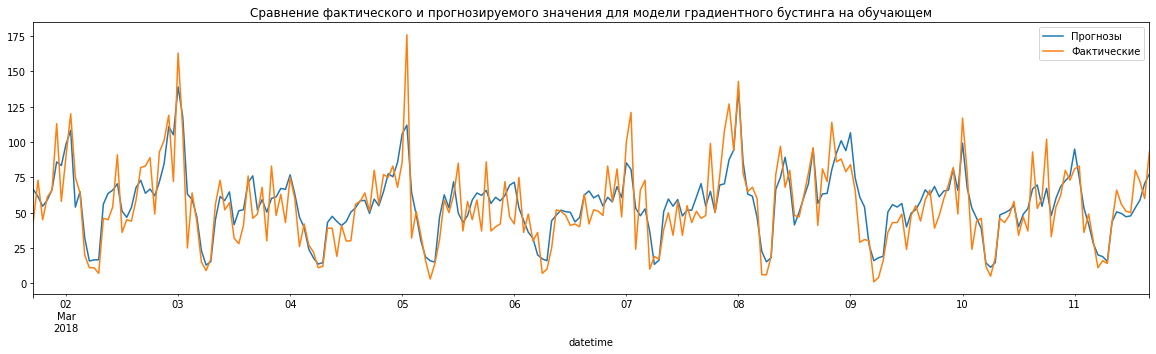

In [24]:
#Прогнозы за 10 дня
pd.DataFrame({'Прогнозы':predict_train,
             'Фактические':y_train})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели градиентного бустинга на обучающем')
plt.show()

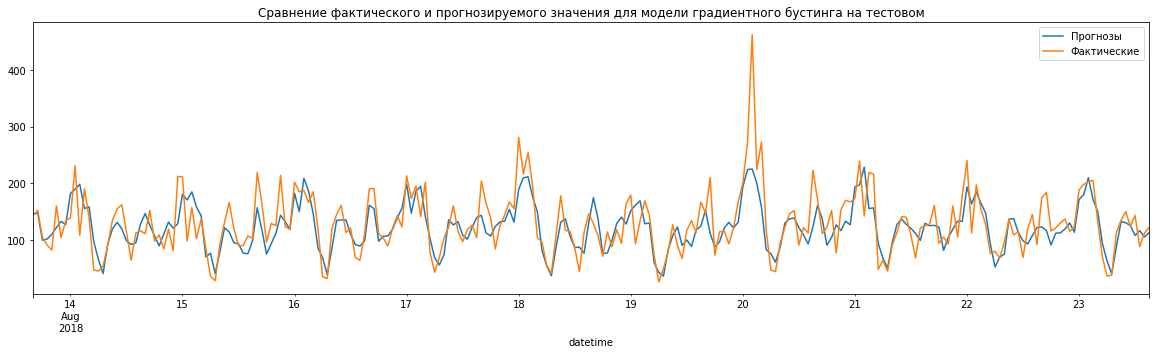

In [25]:
#Прогнозы за 10 дня
pd.DataFrame({'Прогнозы':predict_test,
             'Фактические':y_test})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели градиентного бустинга на тестовом')
plt.show()

In [26]:
forest_model=stat.loc[10,'Модель']
forest_model.fit(X_train, y_train)
predict_train=forest_model.predict(X_train)
predict_test=forest_model.predict(X_test)

train_rmse=mean_squared_error(y_train, predict_train)**0.5
test_rmse=mean_squared_error(y_test, predict_test)**0.5

print('Точность случайного леса на обучающем наборе: {:.3f}'.format(train_rmse))
print('Точность случайного леса на тестовом наборе: {:.3f}'.format(test_rmse))

Точность случайного леса на обучающем наборе: 9.408
Точность случайного леса на тестовом наборе: 44.133


**Вывов**: ошибка rmse на тестовом наборе данных меньше 48 для модели линейной регрессии и случайного леса, что удовлетворяет представленным к модели требованиям. Лучше использовать модель градиентного бустинга, в которой средняя ошибка равна 44 заказам в час на тестовом наборе данных. При СКО в 45 на ресемплированном наборе данных - это достаточно точно

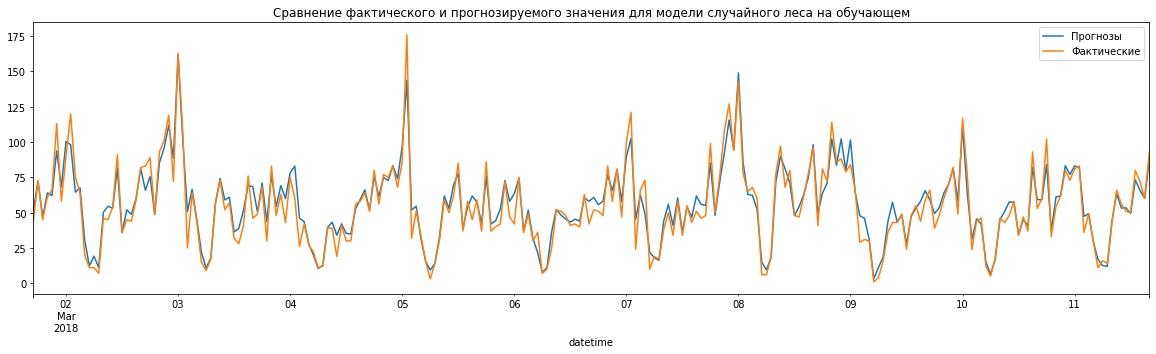

In [27]:
#Прогнозы за 10 дня
pd.DataFrame({'Прогнозы':predict_train,
             'Фактические':y_train})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели случайного леса на обучающем')
plt.show()

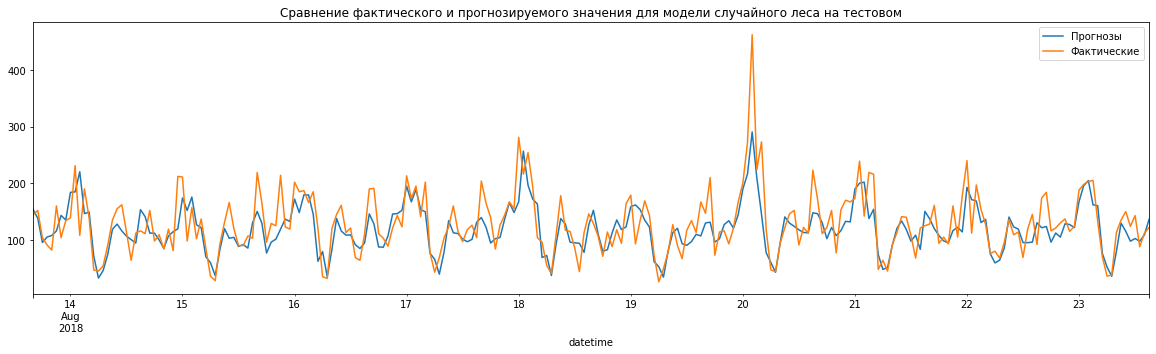

In [28]:
#Прогнозы за 10 дня
pd.DataFrame({'Прогнозы':predict_test,
             'Фактические':y_test})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели случайного леса на тестовом')
plt.show()

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА 2(27/08/2020)</u>
</font>
<font color='green'>
Илья, привет! Здорово ты ещё поработал)<br>
Графики, что на этом периоде построены, показывают, что очень неплохая модель построена<br>
Оставил ещё пару комментариев по лагам и скользящему среднему. Посмотри, пожалуйста.<br>
Также, постарался ответить на твои вопросы.<br>
Буду ждать твоих комментариев по ним и ещё вопросов))<br>


<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Илья, с модельной частью справился хорошо!<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
    
Если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
    
Уверен, что сумев понять главную особенность временных рядов - составляющие ряда и их влияние на прогноз продаж, у тебя появится ещё более уверенный скил и по этой теме.<br>
Готов буду ответить на твои вопросы!<br>
<font color='red'>    
А пока попрошу тебя чуть скорректировать такие моменты:<br>
1) раскрой, пожалуйста, почему именно такие факторы для моделирования выбраны и именно с такими параметрами.<br>
2) Если будет возможность: выведи, пожалуйста графики факт/предсказанное на одном рисунке (обычный линейный график). Чтобы увидеть где основные не "попадалки" модели. Это один из основных инструментов анализа результатов моделирования временных рядов.<br>
Лучше выбрать масштаб, скажем, несколько дней, чтобы увиеть можо было и сравнить каждый час.<br>    
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Хотел бы оставить несколько идей для Ваших будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48